# Parcel delineation
### Originally created by Kristof van Tricht, Vito , rewrite by Jeroen Dries

In [1]:
import openeo
import json
from delineation_openeo import load_udf
from shapely.geometry import shape
import geopandas as gpd
import matplotlib.pyplot as plt
import hvplot
import xarray as xr

In [2]:
eoconn = openeo.connect("openeo.cloud")

## Authenticate

Run this cell again in case you can no longer connect. The token expires after a certain timle.

If you do not have an account yet, openEO platform has free trials:
https://docs.openeo.cloud/join/free_trial.html#step-2-join-openeo-platform-virtual-organization

More info on authentication:
https://docs.openeo.cloud/getting-started/python/#authentication


In [3]:
eoconn.authenticate_oidc()

INFO:openeo.rest.connection:Found OIDC providers: ['egi']
INFO:openeo.rest.connection:No OIDC provider given, but only one available: 'egi'. Using that one.
INFO:openeo.rest.connection:Using default client_id 'openeo-platform-default-client' from OIDC provider 'egi' info.
INFO:openeo.rest.auth.config:File C:\Users\DRIESSEB\AppData\Roaming\openeo-python-client\refresh-tokens.json could be readable by others: mode 666 (expected: 600).
INFO:openeo.rest.connection:Found refresh token: trying refresh token based authentication.
INFO:openeo.rest.auth.oidc:Doing 'refresh_token' token request 'https://aai.egi.eu/oidc/token' with post data fields ['grant_type', 'client_id', 'refresh_token'] (client_id 'openeo-platform-default-client')
INFO:openeo.rest.connection:Obtained tokens: ['access_token', 'id_token', 'refresh_token']
INFO:openeo.rest.auth.config:File C:\Users\DRIESSEB\AppData\Roaming\openeo-python-client\refresh-tokens.json could be readable by others: mode 666 (expected: 600).
INFO:open

Authenticated using refresh token.


<Connection to 'https://openeocloud.vito.be/openeo/1.0.0/' with BearerAuth>

In [4]:
bbox = [5.04776065, 51.213841, 5.06244073, 51.22255853]
year = 2019

startdate=str(year)+'-01-01'
enddate=str(year)+'-09-30'

## Load collection

https://docs.openeo.cloud/getting-started/python/#creating-a-datacube

We apply the 'mask_scl_dilation' process, which is a shortcut for a complex masking procedure based on sen2cor sceneclassification. 
It is very strict in removing clouds and areas around it, to avoid getting pixels polluted by clouds.


In [5]:
s2_bands = eoconn.load_collection(
    "TERRASCOPE_S2_TOC_V2",
    temporal_extent=[startdate, enddate],
    spatial_extent=dict(zip(["west", "south", "east", "north"], bbox)),
    bands=["B04", "B08","SCL"]
)
s2_bands = s2_bands.process("mask_scl_dilation", data=s2_bands, scl_band_name="SCL")

In [6]:
ndviband = s2_bands.ndvi(red="B04", nir="B08")

## Select usable observations

This workflow requires 12 good observations. We will use a user defined function (UDF) to select them.

UDF's are explained here:

https://open-eo.github.io/openeo-python-client/udf.html

In [7]:
# select top 12 usable layers
ndviband=ndviband.apply_dimension(load_udf('udf_reduce_images.py'),dimension='t',runtime="Python")

In [8]:
ndviband.download("results/ndvi_inputs.nc")

In [22]:
dss = xr.open_dataset("results/ndvi_inputs.nc")
dss["var"].hvplot.image().opts(cmap="viridis")

:DynamicMap   [t]
   :Image   [x,y]   (var)


## Apply a tensorflow neural network

We now apply a neural network, that requires 128x128 pixel 'chunks' input, for 12 observations.
To avoid discontinuities between neighboring chunks, we work with an overlap of 32 pixels in all directions.

The 'apply_neighborhood' openEO process was defined for this case:

https://open-eo.github.io/openeo-python-client/api.html?highlight=apply_neigh#openeo.rest.datacube.DataCube.apply_neighborhood


In [16]:
# produce the segmentation image
segmentationband = ndviband.apply_neighborhood(
    lambda data: data.run_udf(udf=load_udf('segmentation.py'), runtime='Python',
                              context={
                                  'startdate': startdate,
                                  'enddate': enddate
                              }),
    size=[
        {'dimension': 'x', 'value': 64, 'unit': 'px'},
        {'dimension': 'y', 'value': 64, 'unit': 'px'}
    ],
    overlap=[
        {'dimension': 'x', 'value': 32, 'unit': 'px'},
        {'dimension': 'y', 'value': 32, 'unit': 'px'}
    ]
)

## Segmentation postprocessing

We postprocess the output from the neural network. This time, we work on larger chunks, to reduce the need for stitching the vector output.

In [17]:
# postprocess for vectorization
segmentationband=segmentationband.apply_neighborhood(
        lambda data: data.run_udf(udf=load_udf('udf_sobel_felzenszwalb.py'), runtime='Python'),
        size=[
            {'dimension': 'x', 'value': 256, 'unit': 'px'},
            {'dimension': 'y', 'value': 256, 'unit': 'px'}
        ],
        overlap=[
            {'dimension': 'x', 'value': 0, 'unit': 'px'},
            {'dimension': 'y', 'value': 0, 'unit': 'px'}
        ]
    )

## Convert to vector

openEO also has a simple vectorization process.

In [18]:
# vectorization
vectorization=segmentationband.raster_to_vector()

result = vectorization.download("results/out.json")

In [19]:
with open("results/out.json") as f:
    polygons = json.load(f)

geom = [shape(p) for p in polygons]
res = gpd.GeoDataFrame(geometry=geom,crs="EPSG:32631")
res.to_file("results/parcels.gpkg", layer='parcels', driver="GPKG")

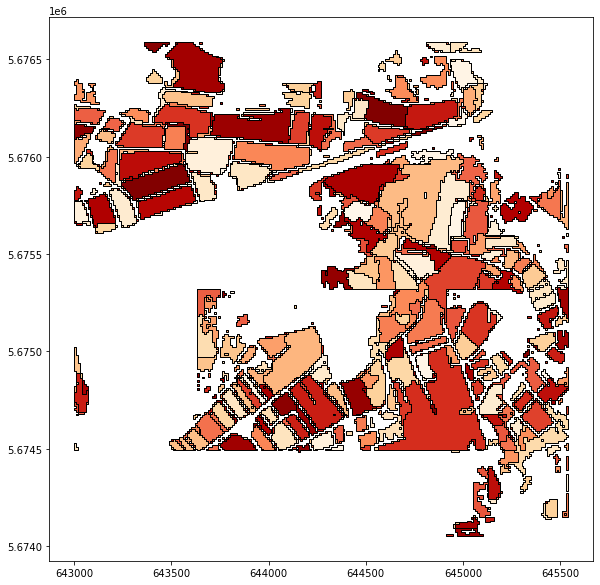

In [20]:
res.plot(cmap='OrRd', figsize=(15, 10), edgecolor="black")
plt.show()